# Notebook for results analysis of GAN training. 

In [1]:
#Import of necessary packages and memory allocation.

%matplotlib inline
import tensorflow as tf
import keras 
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
#config.gpu_options.visible_device_list = str(3)
set_session(tf.Session(config=config))

import h5py as h5
import pandas as pd
from keras.models import load_model
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.util
import sys
import seaborn as sns
import math
#s = np.random.seed(1)

Using TensorFlow backend.


##### Creation of the channels titles : 

In [2]:
#Plot parameters.

sns.set() #Seaborn theme 

from matplotlib import rc
font = {'family' : 'normal','weight' : 'bold', 'size'   : 22}
tick_size = 20
fontweight = 'bold'
#lab_loc = 2
#lab_font_size = 14
#rc('text', usetex=True)
matplotlib.rc('font', **font)
plt.style.use('seaborn')

## Parameters. 

Setting up parameters for figure generations 

In [3]:
#########
multi_train = True  #If the training was in multiple run : True
plot_var = True     #True: plot all cells result ; False : manualy change if plot_var in if True: to plot
save = False         
scale = False
#########
N_fields = 82      #Number of fields == Number of channels in generated tensor. 
N_lvls = 10         #Number of pressure level for 3D variable. 

N_gen = 10800      #Number of generation used for statistic analysis /!\ Memory usage important /!\
N_train = 10800
#indxs = np.random.randint(0,1000,N_gen)
#ind = indxs[0]
#########
lons = np.genfromtxt('/scratch/coop/besombes/Puma_Project/data/raw/lon.csv', delimiter=',')
lat = np.genfromtxt('/scratch/coop/besombes/Puma_Project/data/raw/lat.csv', delimiter=',')

print(lons)
lon_idx = [16,16,32,48]                    #France, north america, ecuador, south america
lat_idx = [5,106,106,106]                  #France, north america, ecuador, south america
fnes = [[16,5],[16,106],[32,106],[48,106]] #Coordinate for distribution comparison at different locations.
L_ind = ['a','b','c','d']


if N_fields==82:
    runnumber_0 = 'RESNET_V8_82l'
    runnumber_1, stop1 = 'RESNET_V8_82l_continue1', 8000 #Name of the generator save file for the 1st restart
    runnumber_2, stop2 = 'RESNET_V8_82l_continue2', 15500 #Name of the generator save file for the 2nd restart
    runnumber_3, stop3 = 'RESNET_V8_82l_continue3b', 23250
    runnumber_4, stop4 = 'RESNET_V8_82l_continue4', 31000
    runnumber = runnumber_4 #Most recent save
elif N_fields==22:
    runnumber_0 = 'RESNET_V8_gual_Gbn'
    runnumber = runnumber_0 #Most recent save







[  0.       2.8125   5.625    8.4375  11.25    14.0625  16.875   19.6875
  22.5     25.3125  28.125   30.9375  33.75    36.5625  39.375   42.1875
  45.      47.8125  50.625   53.4375  56.25    59.0625  61.875   64.6875
  67.5     70.3125  73.125   75.9375  78.75    81.5625  84.375   87.1875
  90.      92.8125  95.625   98.4375 101.25   104.0625 106.875  109.6875
 112.5    115.3125 118.125  120.9375 123.75   126.5625 129.375  132.1875
 135.     137.8125 140.625  143.4375 146.25   149.0625 151.875  154.6875
 157.5    160.3125 163.125  165.9375 168.75   171.5625 174.375  177.1875
 180.     182.8125 185.625  188.4375 191.25   194.0625 196.875  199.6875
 202.5    205.3125 208.125  210.9375 213.75   216.5625 219.375  222.1875
 225.     227.8125 230.625  233.4375 236.25   239.0625 241.875  244.6875
 247.5    250.3125 253.125  255.9375 258.75   261.5625 264.375  267.1875
 270.     272.8125 275.625  278.4375 281.25   284.0625 286.875  289.6875
 292.5    295.3125 298.125  300.9375 303.75   306.5

In [4]:
#Loading dataset and scaling factors (N_fields, 2)= mean and variance for each channel.
if N_fields==82:
    f=h5.File('../data/raw/T42_plasim_100y_10lay_scaled.h5','r')
    _X_train = f['dataset']
    scaling = np.transpose(f['scaling'])
elif N_fields==22:
    _X_train = np.load('../data/raw/x_train_22c_scaled.npy')
    scaling = np.load('../data/raw/scaling_21c.npy')



print(scaling.shape)

(81, 2)


In [5]:
if N_fields==82:
    var = ['ta', 'ua', 'va', 'hus', 'wap', 'zeta', 'd', 'zg']
    lvls = [100, 200,300,400,500,600,700,800,900,1000]
elif N_fields==22:
    var = ['ta', 'ua', 'va', 'wa', 'pl','lat']
    lvls = [200,500,700,850,1000]


chan_titles = []
for i in var:
    for j in lvls:
        chan_titles.append(i+'_z'+str(j))
chan_titles.append('surface pressure')
#chan_titles.append('latitude')

print(chan_titles)

['ta_z100', 'ta_z200', 'ta_z300', 'ta_z400', 'ta_z500', 'ta_z600', 'ta_z700', 'ta_z800', 'ta_z900', 'ta_z1000', 'ua_z100', 'ua_z200', 'ua_z300', 'ua_z400', 'ua_z500', 'ua_z600', 'ua_z700', 'ua_z800', 'ua_z900', 'ua_z1000', 'va_z100', 'va_z200', 'va_z300', 'va_z400', 'va_z500', 'va_z600', 'va_z700', 'va_z800', 'va_z900', 'va_z1000', 'hus_z100', 'hus_z200', 'hus_z300', 'hus_z400', 'hus_z500', 'hus_z600', 'hus_z700', 'hus_z800', 'hus_z900', 'hus_z1000', 'wap_z100', 'wap_z200', 'wap_z300', 'wap_z400', 'wap_z500', 'wap_z600', 'wap_z700', 'wap_z800', 'wap_z900', 'wap_z1000', 'zeta_z100', 'zeta_z200', 'zeta_z300', 'zeta_z400', 'zeta_z500', 'zeta_z600', 'zeta_z700', 'zeta_z800', 'zeta_z900', 'zeta_z1000', 'd_z100', 'd_z200', 'd_z300', 'd_z400', 'd_z500', 'd_z600', 'd_z700', 'd_z800', 'd_z900', 'd_z1000', 'zg_z100', 'zg_z200', 'zg_z300', 'zg_z400', 'zg_z500', 'zg_z600', 'zg_z700', 'zg_z800', 'zg_z900', 'zg_z1000', 'surface pressure']


# Loading generator

        - Loading the generator, and generating N_gen samples that will be scaled using the scaling matrix loaded before


In [6]:
ind = 4115
indx, indf = ind, 0
print(ind)
#fk_imgs=im_sc


sys.path.append('../src/modeling')

sys.path.append('../src/preprocessing')

sys.path.append('../src/preparation')
from SpectralNormalizationKeras import *
from custom_classes import *
from data_preproc import *

try:
    gen = load_model(f'../model/save/{runnumber}/{runnumber}_generator.h5',custom_objects = {'NearestPadding2D': NearestPadding2D,'WrapPadding2D': WrapPadding2D, 'DenseSN' :DenseSN, 'ConvSN2D': ConvSN2D})
except:
    gen = load_model(f'../model/{runnumber}_generator.h5',
          custom_objects = {'NearestPadding2D': NearestPadding2D,'WrapPadding2D': WrapPadding2D, 'DenseSN' :DenseSN, 'ConvSN2D': ConvSN2D})


print('Generating samples...')

4115
Generating samples...


/softs/anaconda3/envs/tf1.12-cuda10-py36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Local quality control - Distribution analysis
We are taking a cell from the domain and plot statistics over the year. 

In [7]:
N_gen = 5000
N_train = 5000

print('Generating samples...')

z = np.random.normal(0,1,(N_gen,64))
fk_imgs = gen.predict(z)
print('Samples generated.')
print('scaling...')
fk_imgs = np.multiply(fk_imgs[:,:,:,:-1],
                    scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]
print('scaled.')
print('Database loading...')

if N_fields==82:
    f=h5.File('../data/raw/T42_plasim_100y_10lay_scaled.h5','r')
    _X_train = f['dataset']
    scaling = np.transpose(f['scaling'])
elif N_fields==22:
    X_train = np.load('../data/raw/x_train_22c_scaled.npy')
    scaling = np.load('../data/raw/scaling_21c.npy')
    
print('Database loaded.')
print('Scaling...')
X_train = np.multiply(_X_train[:N_train,:,:,:],
                    scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]
print('Scaled')

Generating samples...
Samples generated.
scaling...
scaled.
Database loading...
Database loaded.
Scaling...
Scaled


In [8]:
#phase_mean_yr = np.zeros((365,21))
data = {}
#sliced_X = np.zeros(())

X_fr = X_train[:,16,127,:]
for chan in range(21):
    data[chan_titles[chan]] = X_fr[:,chan]


In [9]:

start = pd.to_datetime("05-11-2012")
idx = pd.date_range(start, periods= X_train.shape[0])
df_local = pd.DataFrame(data = data, index = idx) 
df_local.index = idx

#print(idx)
#print(df_local)

In [10]:

#for chan in chan_titles[:20]:
#    fig, ax = plt.subplots(figsize=(16,9))
#    df_local.plot(y = chan, ax = ax)

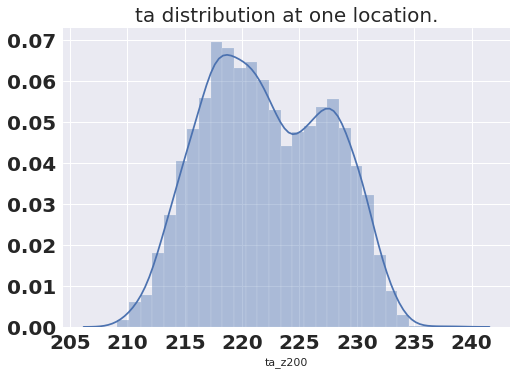

In [11]:

title = 'ta_z200'

for chan in chan_titles[:1]:
    fig, ax = plt.subplots()
    
    #df_local.plot(y = chan, ax = ax, kind = 'hist')
    pl = sns.distplot(df_local[title])
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    pl.axes.set_title(f'{title[:-5]} distribution at one location.', fontsize = 20)
    #df_local.plot(x = chan_titles[5+i], y = chan_titles[10+i], kind = 'boxplot', ax = ax)

In [12]:


def locDist(X, var2plot, px_idx = (0,0), chan_titles = None):
    data = {}
    
    X_fr = X[:,px_idx[0],px_idx[1],:]
    
    for chan in range(21):
        data[chan_titles[chan]] = X_fr[:,chan]
        

    
    start = pd.to_datetime("27-9-2012")
    idx = pd.date_range(start, periods= X.shape[0])
    df_local = pd.DataFrame(data = data, index = idx) 
    df_local.index = idx
    
    for chan in var2plot:
        fig, ax = plt.subplots()

    sns.distplot(df_local[var2plot[0]])
    return df_local[var2plot[0]]

def locDist2(X1, X2, var2plot, px_idx = (0,0), chan_titles = None, save=None):
    data1 = {}
    data2 = {}
    
    X_fr1 = X1[:,px_idx[0],px_idx[1],:]
    
    X_fr2 = X2[:,px_idx[0],px_idx[1],:]
    
    for chan in range(21):
        data1[chan_titles[chan]] = X_fr1[:,chan]
        data2[chan_titles[chan]] = X_fr2[:,chan]
        
    
    start     = pd.to_datetime("27-9-2012")
    idx       = pd.date_range(start, periods= X1.shape[0])
    df_local1 = pd.DataFrame(data = data1)
    
    df_local2 = pd.DataFrame(data = data2)
    #df_local.index = idx
    
    for chan in var2plot:
        fig, ax = plt.subplots(figsize=(16,9))
        plt.suptitle(f'Comparison of {var2plot[0]} distribution at one pixel : \n {px_idx} between database and generations.'
                    , fontsize = 24, fontweight = fontweight)
        
        fig.subplots_adjust(top = 0.9,left=0.1,right=.9,bottom=0.08, wspace = 0.1, hspace = 0.3)
        
        plt.subplot(1,1,1)
        sns.distplot(df_local1[var2plot[0]], rug=False, hist=True, kde = True,
                     norm_hist = False, color = 'g', bins = None)
        
        
        sns.distplot(df_local2[var2plot[0]], rug=False, hist=True, kde = True,
                     norm_hist = False, color = 'b', bins = None)
        
        plt.xlabel(var2plot[0][:-5], fontsize = 20, fontweight = fontweight)
        plt.legend(['Database',"Generated" ], fontsize = 20)
        plt.tick_params(axis='both', labelsize=tick_size)
        if save != None:
            plt.savefig(f'./fig_{N_fields}c/{save}')
    return df_local1[var2plot[0]], df_local2[var2plot[0]]



def maxDist(X, var2plot,  chan_titles = None):
    data = {}
    
    X_fr = X
    
    for chan in range(21):
        data[chan_titles[chan]] = np.amax(X_fr[:,:,:,chan], axis = (1,2))
    
    #start = pd.to_datetime("27-9-2012")
    #idx = pd.date_range(start, periods= X.shape[0])
    df_local = pd.DataFrame(data = data) 
    #df_local.index = idx
    
    for chan in var2plot:
        fig, ax = plt.subplots()

    sns.distplot(df_local[var2plot[0]])
    return df_local[var2plot[0]]

def crossDist(X, var2plot, px_idx = (16,127), chan_titles = None, axlab = None):
    data = {}
    
    #X_fr = X[:, px_idx[0], px_idx[1], :]
    X_fr = np.mean(X[:, :, :, :], axis = (1,2))
    
    for chan in range(21):
        data[chan_titles[chan]] = X_fr[:,chan]
    

    df_local = pd.DataFrame(data = data) 

    for chan in var2plot:
        #fig, ax = plt.subplots()
        sns.jointplot(df_local[var2plot[0]], df_local[var2plot[1]], kind = 'hex')
    return df_local[var2plot[0]],  df_local[var2plot[1]]

def verticalLocDist2(X1, X2, var2plot, px_idx = (0,0), chan_titles = None, save=None, axlab = None, legend = None):
    N_samples = min(X1.shape[0], X2.shape[0])
    
    data1 = {}
    data2 = {}
    
    X_fr1 = X1[:N_samples,px_idx[0],px_idx[1],:]
    
    X_fr2 = X2[:N_samples,px_idx[0],px_idx[1],:]
    
    for chan in range(21):
        data1[chan_titles[chan]] = X_fr1[:N_samples,chan]
        data2[chan_titles[chan]] = X_fr2[:N_samples,chan]
        
    
    start     = pd.to_datetime("27-9-2012")
    idx       = pd.date_range(start, periods= N_samples)
    df_local1 = pd.DataFrame(data = data1, index = idx)
    
    df_local2 = pd.DataFrame(data = data2, index = idx)
    #df_local.index = idx
    
    vertical_val1 = np.zeros((N_samples,N_lvls))
    vertical_val2 = np.zeros((N_samples,N_lvls))
    lvlz = [200, 500, 700, 850, 1000]
    y = np.ones((N_samples,N_lvls))
    
    for i,chan in enumerate(var2plot):
        vertical_val1[:,i] = df_local1[chan]
        vertical_val2[:,i] = df_local2[chan]
        y[:,i] *= lvlz[i]
        
        #std1.append(np.std(df_local1[chan], axis = 0))
        #std2.append(np.std(df_local2[chan], axis = 0))
    fig, ax = plt.subplots(figsize=(16,9))
    plt.suptitle(f'Comparison of {var2plot[0]} distribution at one pixel : \n {px_idx} between database and generations.'
                , fontsize = 24, fontweight = fontweight)
    
    fig.subplots_adjust(top = 0.9,left=0.1,right=.9,bottom=0.08, wspace = 0.3, hspace = 0.3)
    
    plt.subplot(1,1,1)
    sns.scatterplot(y = np.mean(vertical_val1, axis = 0), x=[200, 500, 700, 850, 1000], s = 25)
    sns.scatterplot(y = np.mean(vertical_val2, axis = 0), x=[200, 500, 700, 850, 1000], s = 25)
    print(vertical_val1.shape, vertical_val2.shape, y.shape)
    #sns.lineplot(y = vertical_val1[:,i], x=y[:,i])
    #sns.lineplot(x = vertical_val2[:,i], y=y[:,i])
    
    if axlab is not None:
        plt.xlabel(axlab[0], fontsize = 20, fontweight = fontweight)
        plt.ylabel(axlab[1], fontsize = 20, fontweight = fontweight)
        plt.tick_params(axis='both', labelsize=tick_size)
    if legend is not None:
        plt.legend(legend, fontsize = 20)
    if save != None:
        plt.savefig(f'./fig_{N_fields}c/{save}')
    return #vertical_val1, vertical_val2

[ 87.86379884  85.09652699  82.31291295  79.52560657  76.73689968
  73.94751515  71.15775201  68.36775611  65.57760701  62.7873518
  59.99702011  57.20663153  54.41619953  51.62573367  48.83524097
  46.04472663  43.25419467  40.46364818  37.67308963  34.88252099
  32.09194388  29.30135962  26.51076933  23.72017393  20.92957425
  18.13897099  15.34836476  12.55775612   9.76714556   6.97653355
   4.18592053   1.39530691  -1.39530691  -4.18592053  -6.97653355
  -9.76714556 -12.55775612 -15.34836476 -18.13897099 -20.92957425
 -23.72017393 -26.51076933 -29.30135962 -32.09194388 -34.88252099
 -37.67308963 -40.46364818 -43.25419467 -46.04472663 -48.83524097
 -51.62573367 -54.41619953 -57.20663153 -59.99702011 -62.7873518
 -65.57760701 -68.36775611 -71.15775201 -73.94751515 -76.73689968
 -79.52560657 -82.31291295 -85.09652699 -87.86379884]


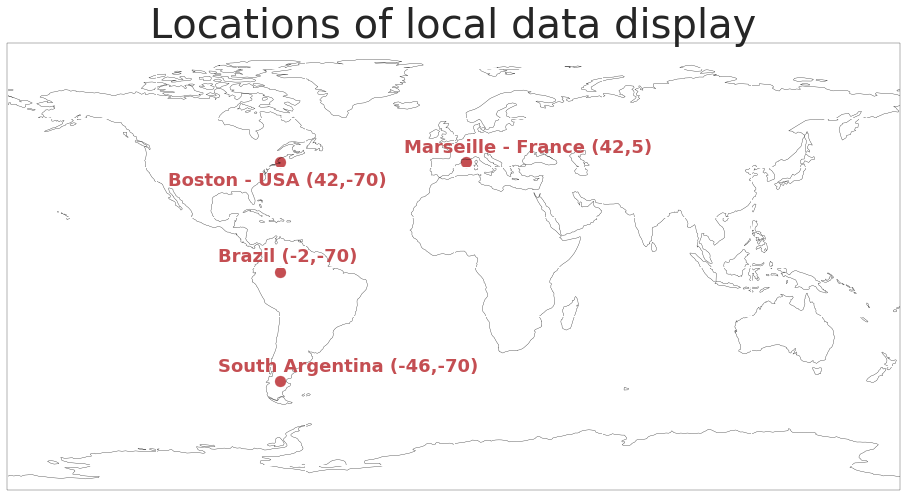

In [13]:
#[[16,127],[16,64], [32,64], [48,64]]
print(lat)
fig, ax = plt.subplots(figsize = (16,9), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0.)})
ax.coastlines(resolution='110m')
subtitle = ['Marseille - France (42,5)', 'Boston - USA (42,-70)', 'Brazil (-2,-70)', 'South Argentina (-46,-70)']

#plt.title(chan_titles[k])

#ax = plt.axes(projection=ccrs.PlateCarree())
#ax.coastlines()
img = np.zeros((64,128))


lon_idx = [16,16,32,48] #France, north america, ecuador, south america
lat_idx = [5,106,106,106] ##France, north america, ecuador, south america

lat_ = [42,42,-2,-46] #France, north america, ecuador, south america
lon_ = [5,-70,-70,-70] ##France, north america, ecuador, south america


for i in range(4):
    for j in range(1):
        for k in range(1):
            img[lon_idx[i]-k, lat_idx[i]-j] = 1.
    if i ==1:
        ax.text(lon_[i]-45, lat_[i]-9, subtitle[i], color = 'r', fontsize = 18, transform=ccrs.PlateCarree())
    else:
        ax.text(lon_[i]-25, lat_[i]+4, subtitle[i], color = 'r', fontsize = 18, transform=ccrs.PlateCarree())
#im = plt.imshow(img, transform=ccrs.PlateCarree(central_longitude=170))
plt.scatter(lon_, lat_, s = 120, c='r', alpha = 1)
ax.gridlines()
ax.set_extent((-180,180,-90,90))
plt.title('Locations of local data display', fontsize = 40)

if True:
    plt.savefig(f'./fig_{N_fields}c/scatter_idx.pdf')

In [26]:
import scipy as scp
def locsDist(X1, var2plot=None, X2 = None, px_idx =[[16,5],[16,106],[32,106],[48,106]], chan_titles = None, save = None):
    if X2 is not None :
        N_samples = min(X1.shape[0], X2.shape[0])
    else:
         N_samples = X1.shape[0]
            
    leg = True
    fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(15,12))
    fig.suptitle(f' Temperature distribution at different pixels.'
                            , fontsize = 24, fontweight = fontweight)
    fig.subplots_adjust(top = 0.87,left=0.1,right=.9,bottom=0.08, wspace = 0.16, hspace = 0.45)
    subtitle = ['(a) \n Marseille - France (42,5)', '(b) \n Boston - USA (42,-70)', '(c) \n Brazil (-2,-70)', '(d) \n South Argentina (-46,-70)']
    
    for i in range(len(px_idx)):
        data1 = {}
        X_fr1 = X1[:N_samples, px_idx[i][0], px_idx[i][1], :]
        
        if X2 is not None:
            data2 = {}
            X_fr2 = X2[:N_samples, px_idx[i][0], px_idx[i][1], :]

        for chan in range(21):
            data1[chan_titles[chan]] = X_fr1[:,chan]
            if X2 is not None:
                data2[chan_titles[chan]] = X_fr2[:,chan]

        start     = pd.to_datetime("27-9-2012")
        idx       = pd.date_range(start, periods= X1.shape[0])
        df_local1 = pd.DataFrame(data = data1)
        
        if X2 is not None:
            df_local2 = pd.DataFrame(data = data2)

        for chan in var2plot:
            ax = plt.subplot(2,2,i+1)
            
            sns.distplot(df_local1[var2plot[0]], rug=False, hist=True, kde = True,
                         norm_hist = False, color = 'g', bins = None)
            
            if X2 is not None:
                sns.distplot(df_local2[var2plot[0]], rug=False, hist=True, kde = True,
                             norm_hist = False, color = 'b', bins = None)
                wd_dist = scp.stats.wasserstein_distance((df_local1[var2plot[0]]-scaling[9,0])/scaling[9,1],
                                                         (df_local2[var2plot[0]]-scaling[9,0])/scaling[9,1])
                ax.set_title(f'{subtitle[i]} \n wasserstein distance : {wd_dist:.2}', fontsize = 20)
                if leg:
                    plt.legend(['database','generated'], fontsize = 15)
                    leg=False
            ax.set_xlabel(var2plot[0][:], fontsize = 20)
            plt.tick_params(axis='both', labelsize=15)
        
    if save != None:
        plt.savefig(f'./fig_{N_fields}c/{save}')
    return #df_local[var2plot[0]]

(5000, 64, 128, 81)


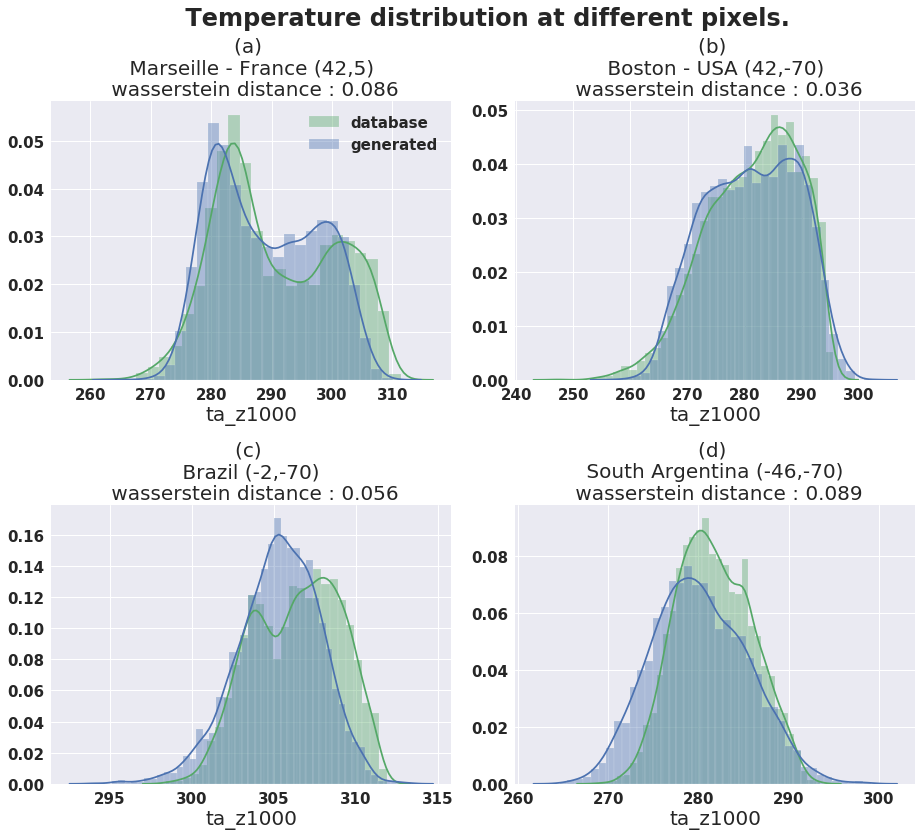

In [27]:
print(fk_imgs.shape)

#print(X_train[np.sort(np.random.randint(0,N_gen,N_gen)),:,:,:])
aaa = locsDist(X_train[:,:,:,:],  X2 = fk_imgs[:N_gen,:,:,:],
               px_idx =[[16,5],[16,106],[32,106],[48,106]], var2plot=['ta_z1000'],
               chan_titles = chan_titles, save = 'Temp_db_gen_pxs.pdf')
#print(aaa)

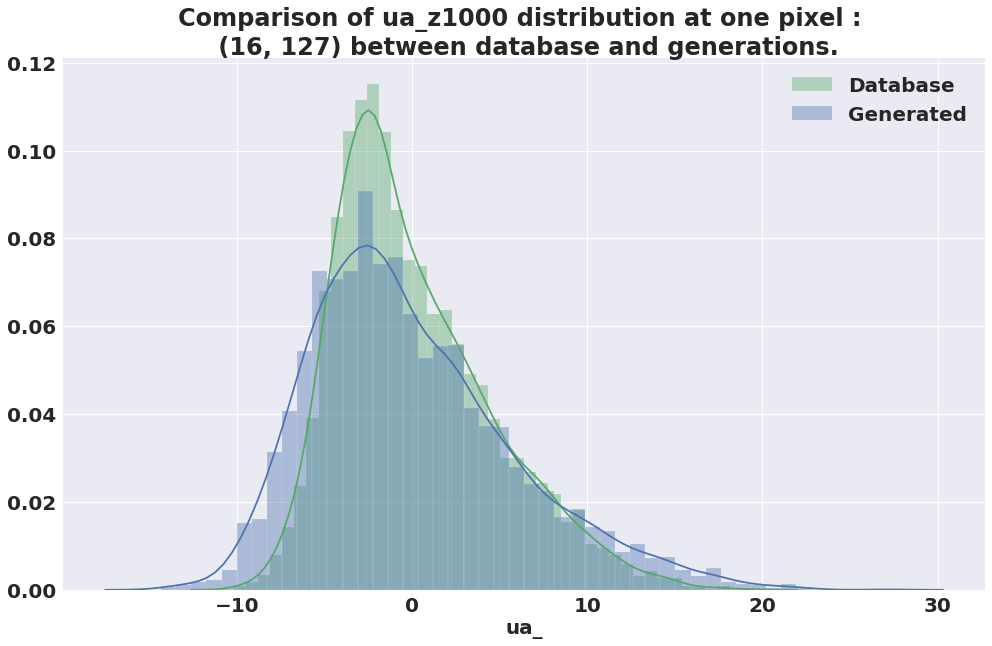

In [28]:
a3 = locDist2(X_train, fk_imgs, ['ua_z1000'], px_idx = (16,127), chan_titles = chan_titles)

In [29]:
def verticalLocDist2(X1, X2, var2plot, px_idx = (0,0), chan_titles = None, save=None, axlab = None, legend = None):
    data1 = {}
    data2 = {}
    
    N_samples = min(X1.shape[0], X2.shape[0])
    
    X_fr1 = X1[:N_samples, px_idx[0], px_idx[1],:]
    
    X_fr2 = X2[:N_samples, px_idx[0], px_idx[1],:]
    
    for chan in range(21):
        data1[chan_titles[chan]] = X_fr1[:30000,chan]
        data2[chan_titles[chan]] = X_fr2[:30000,chan]
        
    
    start     = pd.to_datetime("27-9-2012")
    idx       = pd.date_range(start, periods= X1.shape[0])
    
    df_local1 = pd.DataFrame(data = data1)
    df_local2 = pd.DataFrame(data = data2)
    #df_local.index = idx
    
    vertical_val1 = np.zeros((N_samples*5))
    vertical_val2 = np.zeros((N_samples*5))
    lvlz = [200, 500, 700, 850, 1000]
    y = np.ones((N_samples*5))
    
    for i,chan in enumerate(var2plot):
        vertical_val1[N_samples*i:N_samples*(i+1)] = df_local1[chan]
        vertical_val2[N_samples*i:N_samples*(i+1)] = df_local2[chan]
        y[N_samples*i:N_samples*(i+1)] = lvlz[i]
    return pd.DataFrame(dict(x=vertical_val1, g=y)), pd.DataFrame(dict(x=vertical_val2, g=y)) 

In [30]:

var2plot = 'ta'
df_db, df_gen = verticalLocDist2(X_train, fk_imgs, px_idx = (16,127), legend = ['Dataset', 'Generated'],
                       var2plot = [var2plot+'_z200', var2plot+'_z500', var2plot+'_z700', var2plot+'_z1000'],
                       chan_titles = chan_titles, save = 'Temp_db_pxs.pdf', axlab=[var, 'Pressure level (hPa)'])

In [31]:
df_db.head()
df_gen.head()
#df_merged.head()

,x,g
0,227.578534,200.0
1,223.859967,200.0
2,220.228189,200.0
3,217.698669,200.0
4,222.114565,200.0


In [32]:
# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m



In [33]:
def DF(X1, X2, var2plot, px_idx = (0,0), chan_titles = None, save=None, axlab = None, legend = None):
    data1 = {}
    data2 = {}
    
    N_samples = min(X1.shape[0], X2.shape[0])
    
    X_fr1 = X1[:N_samples,px_idx[0],px_idx[1],:]
    
    X_fr2 = X2[:N_samples,px_idx[0],px_idx[1],:]
    
    for chan in range(21):
        data1[chan_titles[chan]] = X_fr1[:N_samples,chan]
        data2[chan_titles[chan]] = X_fr2[:N_samples,chan]
        
    
    start     = pd.to_datetime("27-9-2012")
    idx       = pd.date_range(start, periods= X1.shape[0])
    
    df_local1 = pd.DataFrame(data = data1)
    df_local2 = pd.DataFrame(data = data2)
    #df_local.index = idx
    
    vertical_val1 = np.zeros((N_samples*5))
    vertical_val2 = np.zeros((N_samples*5))
    lvlz = [200, 500, 700, 850, 1000]
    y = np.ones((N_samples*5))
    
    for i,chan in enumerate(var2plot):
        vertical_val1[N_samples*i:N_samples*(i+1)] = df_local1[chan]
        vertical_val2[N_samples*i:N_samples*(i+1)] = df_local2[chan]
        y[N_samples*i:N_samples*(i+1)] = lvlz[i]
    return pd.DataFrame(dict(x_db=vertical_val1, x_gen= vertical_val2, g=y))

def DF2(X1, X2, var2plot, px_idx = (0,0), chan_titles = None, save=None, axlab = None, legend = None):
    data1 = {}
    data2 = {}
    N_samples = min(X1.shape[0], X2.shape[0])
    X_fr1 = X1[:N_samples,px_idx[0],px_idx[1],:]
    
    X_fr2 = X2[:N_samples,px_idx[0],px_idx[1],:]
    
    for chan in range(21):
        data1[chan_titles[chan]] = X_fr1[:N_samples,chan]
        data2[chan_titles[chan]] = X_fr2[:N_samples,chan]
        
    
    start     = pd.to_datetime("27-9-2012")
    idx       = pd.date_range(start, periods= X1.shape[0])
    
    df_local1 = pd.DataFrame(data = data1)
    df_local2 = pd.DataFrame(data = data2)
    #df_local.index = idx
    
    vertical_val1 = np.zeros((N_samples*N_lvls))
    vertical_val2 = np.zeros((N_samples*N_lvls))
    lvlz = [200, 500, 700, 850, 1000]
    y = np.ones((N_samples*N_lvls))
    
    for i,chan in enumerate(var2plot):
        vertical_val1[N_samples*i:N_samples*(i+1)] = df_local1[chan]
        vertical_val2[N_samples*i:N_samples*(i+1)] = df_local2[chan]
        y[N_samples*i:N_samples*(i+1)] = lvlz[i]
    
    df_db = pd.DataFrame(dict(x=vertical_val1, g=y, origin = 'database'))
    df_gen = pd.DataFrame(dict(x=vertical_val2, g=y, origin = 'generated'))
    df = pd.concat([df_db, df_gen])
    return df

In [34]:
if N_fields == 82:
    df_merged = DF(X_train, fk_imgs, px_idx = (16,127), legend = ['Dataset', 'Generated'],
                           var2plot = [var2plot+'_z200', var2plot+'_z500', var2plot+'_z700', var2plot+'_z800', var2plot+'_z1000'],
                           chan_titles = chan_titles, save = 'Temp_db_pxs.pdf', axlab=[var2plot, 'Pressure level (hPa)'])
    df_merged2 = DF2(X_train, fk_imgs, px_idx = (16,127), legend = ['Dataset', 'Generated'],
                           var2plot = [var2plot+'_z200', var2plot+'_z500', var2plot+'_z700', var2plot+'_z800', var2plot+'_z1000'],
                           chan_titles = chan_titles, save = 'Temp_db_pxs.pdf', axlab=[var2plot, 'Pressure level (hPa)'])
elif N_fields == 22:
    df_merged = DF(X_train, fk_imgs, px_idx = (16,127), legend = ['Dataset', 'Generated'],
                           var2plot = [var2plot+'_z200', var2plot+'_z500', var2plot+'_z700', var2plot+'_z850', var2plot+'_z1000'],
                           chan_titles = chan_titles, save = 'Temp_db_pxs.pdf', axlab=[var2plot, 'Pressure level (hPa)'])
    df_merged2 = DF2(X_train, fk_imgs, px_idx = (16,127), legend = ['Dataset', 'Generated'],
                           var2plot = [var2plot+'_z200', var2plot+'_z500', var2plot+'_z700', var2plot+'_z850', var2plot+'_z1000'],
                           chan_titles = chan_titles, save = 'Temp_db_pxs.pdf', axlab=[var2plot, 'Pressure level (hPa)'])

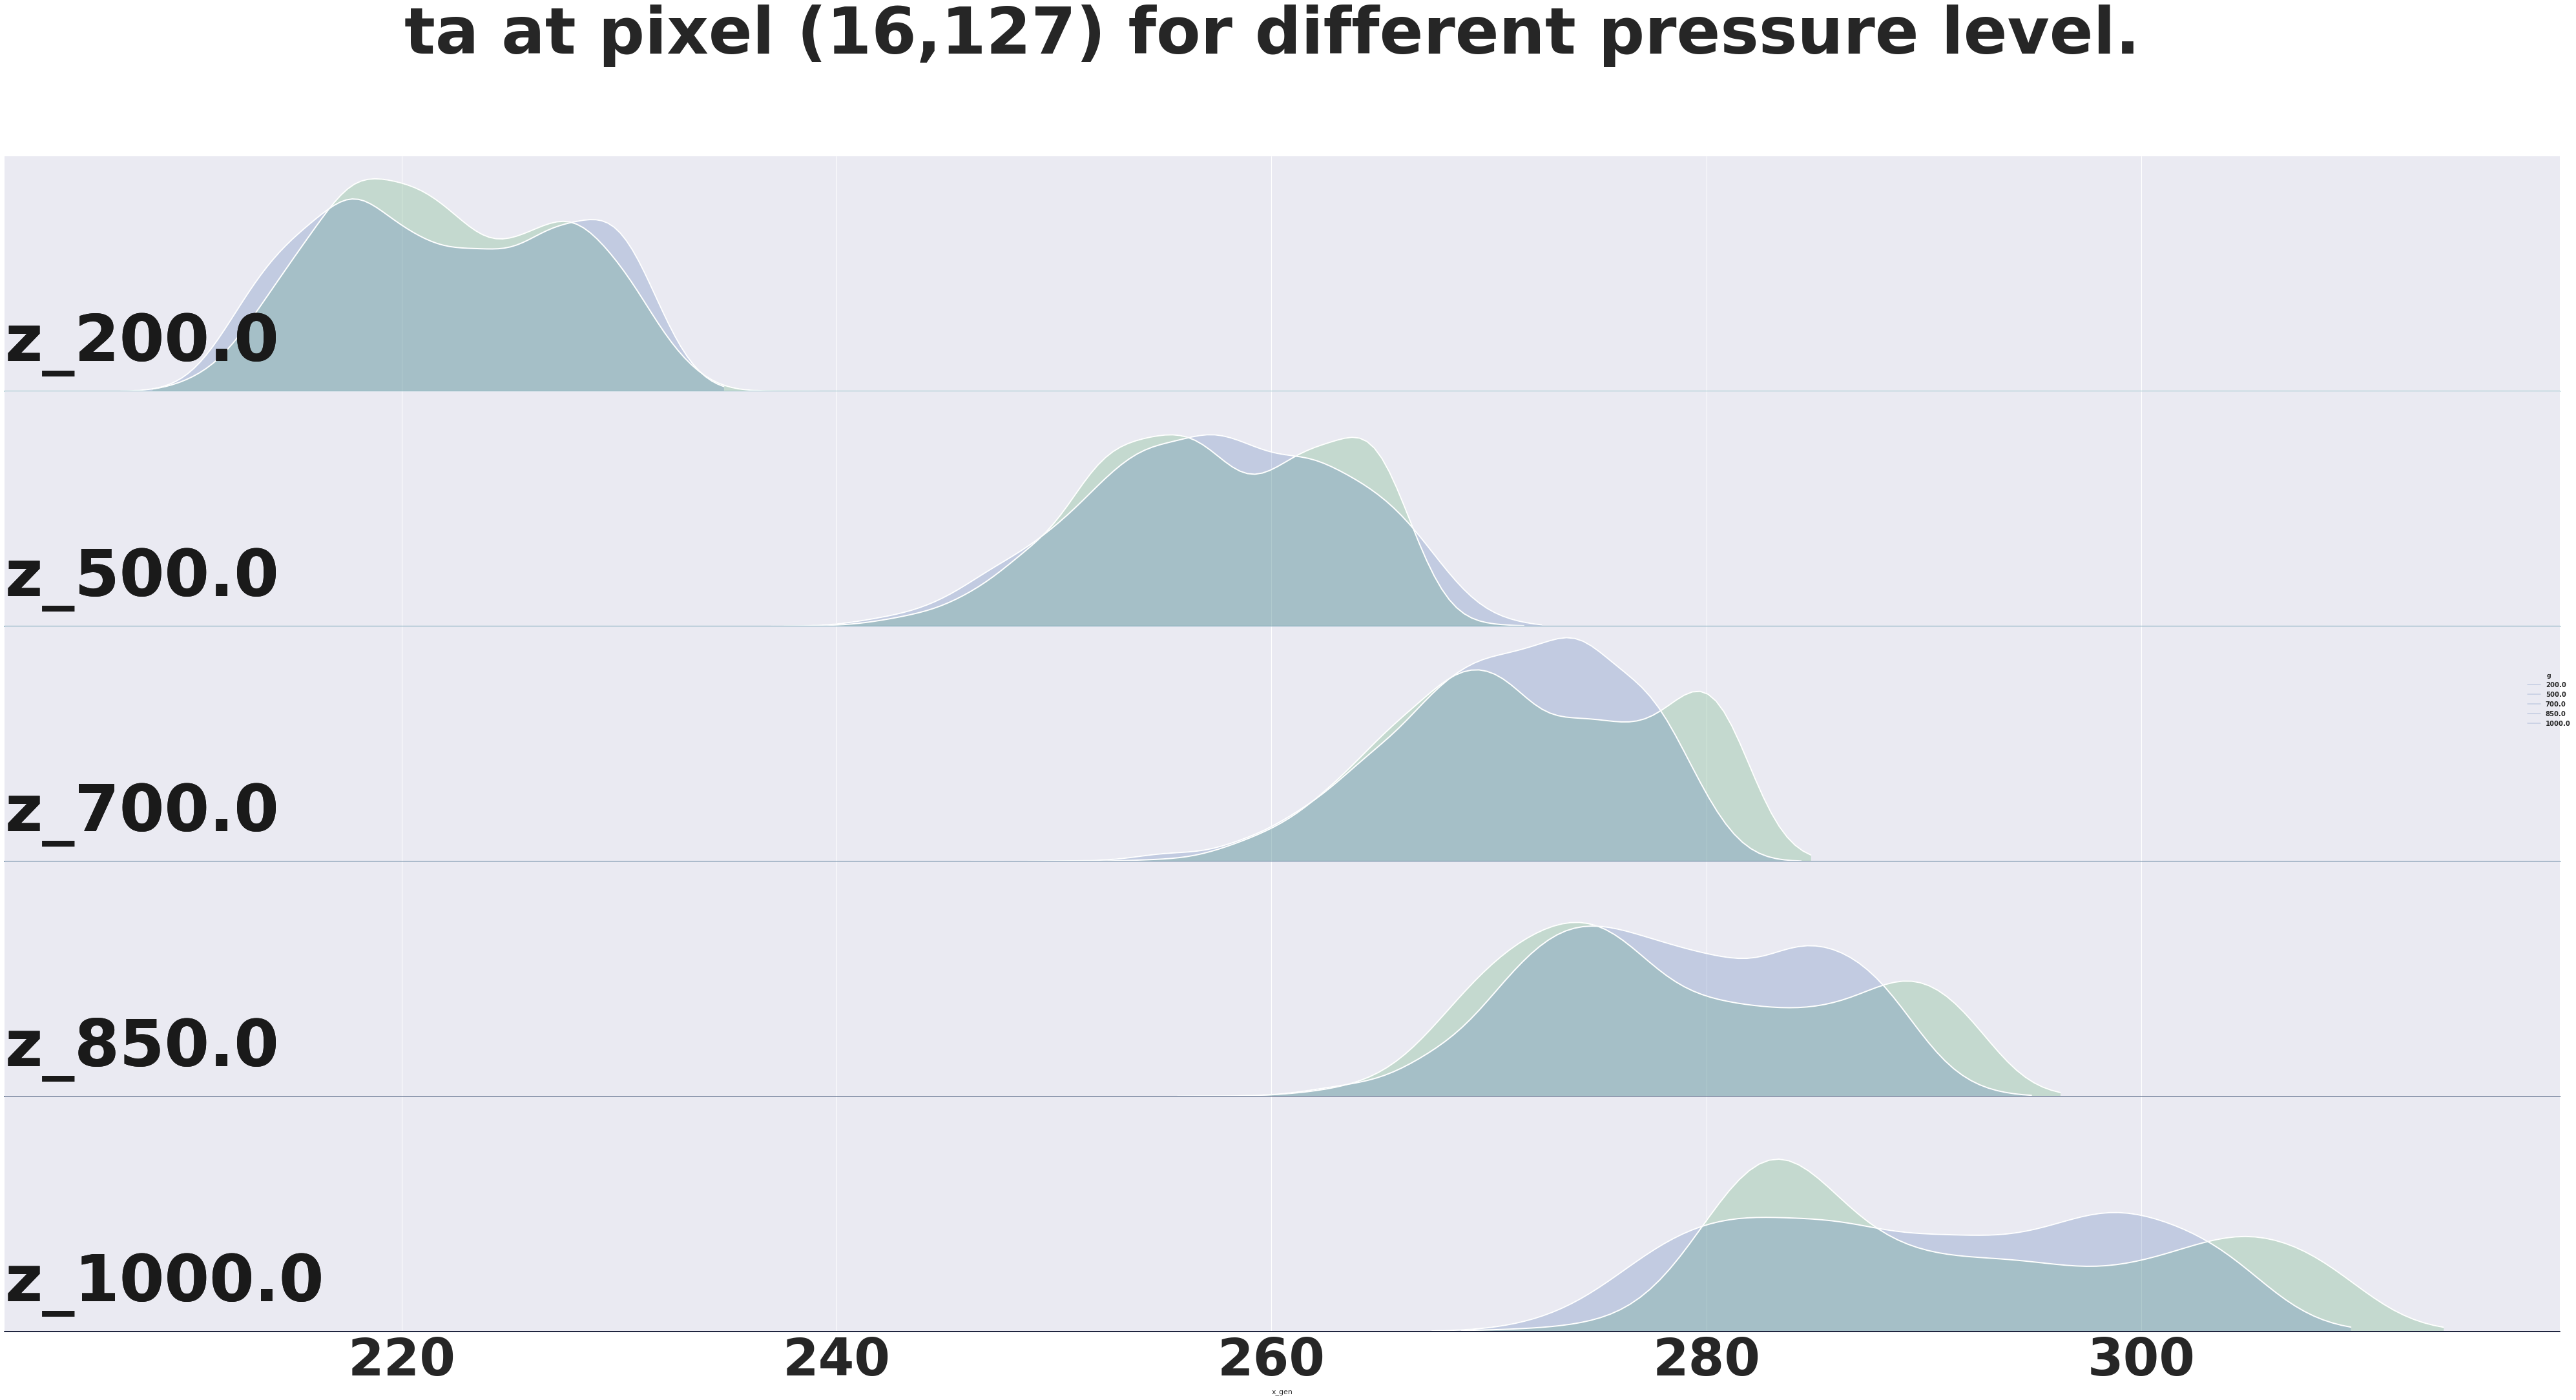

In [35]:
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(5, rot=-.25, light=.7)
g = sns.FacetGrid(df_merged, row="g", hue="g", aspect=10,
                  height=5.5, palette=pal)
#g2 = sns.FacetGrid(df_gen, row="g", hue="g", aspect=15, height=.5, palette=pal)



# Draw the densities in a few steps
g.map(sns.kdeplot, "x_db", clip_on=False, shade=True,
      alpha=0.25, lw=1.5, bw=.2, color = 'g')
g.map(sns.kdeplot, "x_db", clip_on=False, color="w", lw=2, bw=.2)

(g.map(sns.kdeplot, "x_gen", clip_on=False, shade=True,
      alpha=0.25, lw=1.5, bw=.2, color = 'b').add_legend())
g.map(sns.kdeplot, "x_gen", clip_on=False, color="w", lw=2, bw=.2)

g.map(plt.axhline, y=0, lw=2, clip_on=False)

#g2.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
#g2.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
#g2.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, 'z_'+label, fontsize =100 ,fontweight="bold", color='k',
            ha="left", va="center", transform=ax.transAxes)
    #plt.legend(['database','generated'], fontsize = 20)
    ax.tick_params(axis='x', labelsize=80)


g.map(label, "x_db")
g.map(label, "x_gen")

#g2.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=0)
#g2.fig.subplots_adjust(hspace=0)
#g.set_title("deeeeee")
# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
g.fig.suptitle(var2plot+' at pixel (16,127) for different pressure level.', fontsize = 100,fontweight="bold", y = 1.1)
#g2.set(yticks=[])
#g2.set_titles("")
#g2.despine(bottom=True, left=True)

if True:
    plt.savefig(f'./fig_{N_fields}c/vertical_ta.pdf')

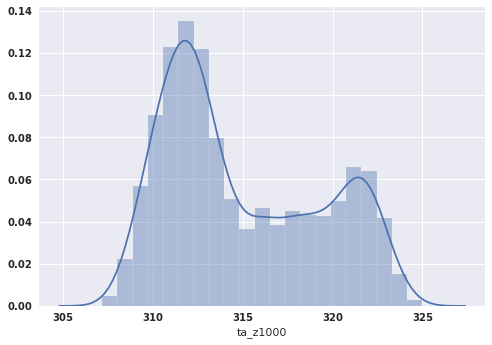

In [36]:
#locDist2(_X_train, ['temperature_z200'], px_idx = (16,127), chan_titles = chan_titles)
a = maxDist(X_train, ['ta_z1000'], chan_titles = chan_titles)

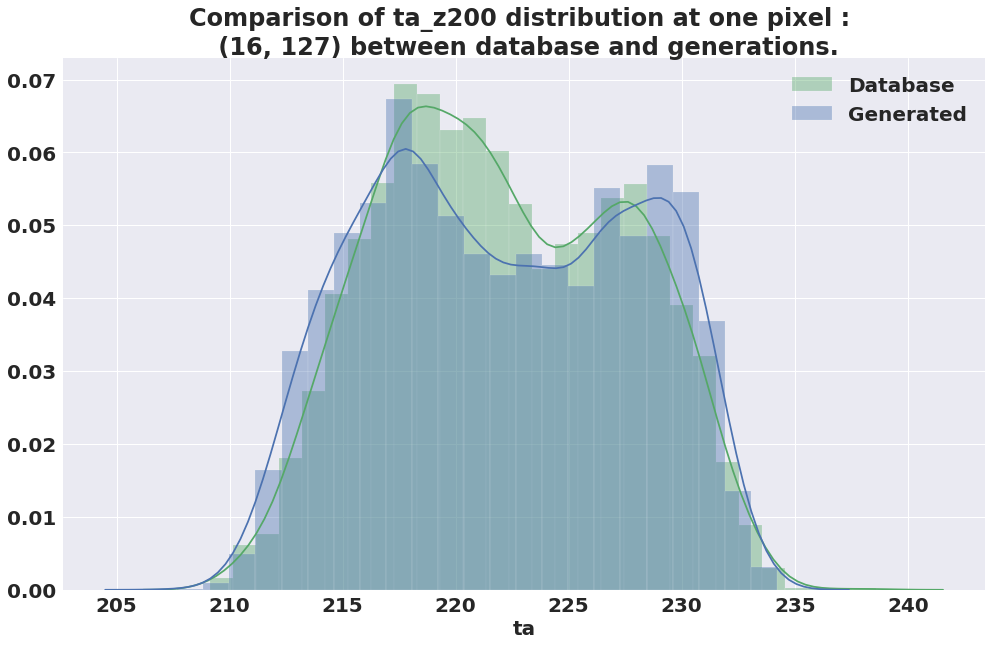

In [37]:
#a1 = locDist(_X_train, ['temperature_z200'], px_idx = (16,127), chan_titles = chan_titles)
#a2 = locDist(fk_imgs, ['temperature_z200'], px_idx = (16,127), chan_titles = chan_titles)
a3 = locDist2(X_train, fk_imgs, ['ta_z200'], px_idx = (16,127), chan_titles = chan_titles, save='temperature_z200_dist_comparisons.pdf')

In [38]:
#a1 = maxDist(X_train, ['temperature_z200'], chan_titles = chan_titles)
#a2 = maxDist(fk_imgs, ['temperature_z200'], chan_titles = chan_titles)

In [39]:
#a1 = crossDist(X_train, ['velocity_X_z200', 'velocity_Y_z200'], px_idx = (16,127), chan_titles = chan_titles)
#a2 = crossDist(fk_imgs, ['velocity_X_z200', 'velocity_Y_z200'], px_idx = (16,127), chan_titles = chan_titles)

In [40]:
N = 50
c_index = 4
print(X_train.shape)
dfc = pd.DataFrame(data = (X_train[:N,:,:,c_index]).reshape(N,64*128), index = idx[:N]) 

(5000, 64, 128, 81)


In [41]:
correl_db = dfc.corr()


In [42]:
#print(correl[0].values.shape)
#aaa = correl[12,:].reshape(64,128)

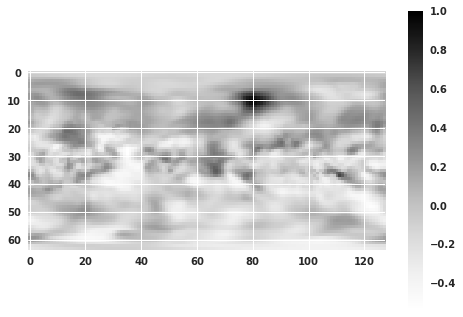

In [43]:
plt.imshow(correl_db[1360].values.reshape(64,128))
plt.colorbar()
#plt.scatter(0,0)

In [44]:

print(fk_imgs.shape)
dfcfk = pd.DataFrame(data = (fk_imgs[:N,:,:,c_index]*scaling[c_index,1]+scaling[c_index,0]).reshape(N,64*128), index = idx[:N]) 

(5000, 64, 128, 81)


In [45]:
correl_gen = dfcfk.corr()

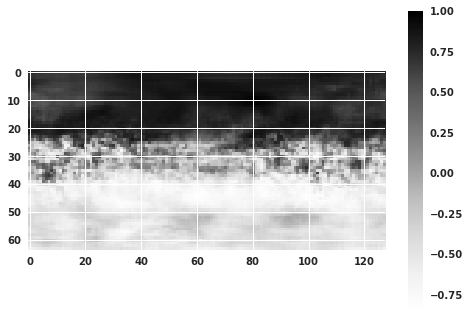

In [46]:
plt.imshow(correl_gen[1360].values.reshape(64,128))
plt.colorbar()
#plt.scatter(0,0)

# 

In [47]:
#sns.distplot([a1,a2])

In [48]:
#phase_mean_yr = np.zeros((365,21))
data = {}
#sliced_X = np.zeros(())

X_fr = X_train[:,16,127,:]
for chan in range(21):
    data[chan_titles[chan]] = X_fr[:,chan]

Text(0.5, 1.0, 'surface pressure')

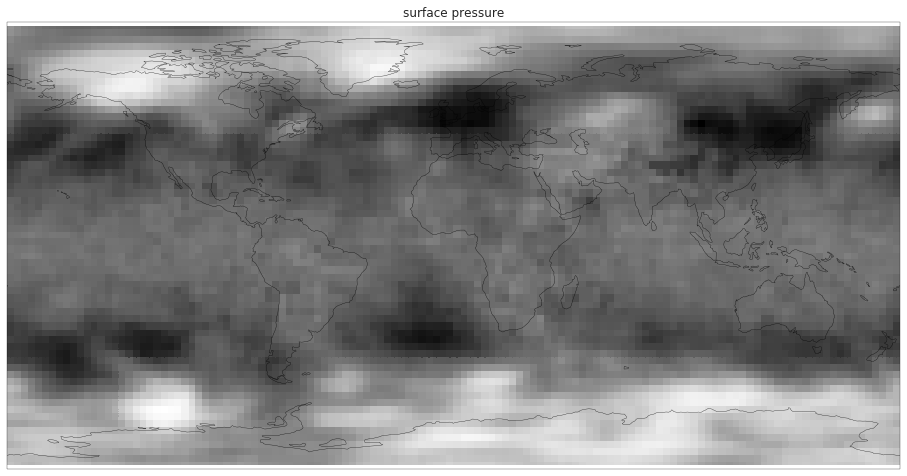

In [49]:
plt.figure(figsize=(16,9))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
ax.coastlines()
plt.imshow(fk_imgs[0,:,:,-2],transform=ccrs.PlateCarree(central_longitude=180.))
#plt.contourf(fk_imgs[j,:,:,k],transform=ccrs.PlateCarree(central_longitude=180.))
plt.title(chan_titles[-1])

In [50]:
#for i in range(fk_imgs.shape[-1]):
#    plt.figure()
#    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
#    ax.coastlines()
#    plt.imshow((np.mean(fk_imgs[:,:,:,i], axis = 0) - np.mean(X_train[:fk_imgs.shape[0],:,:,i], axis = 0))**2, 
#               transform=ccrs.PlateCarree(central_longitude=180.))
#    #plt.contourf(fk_imgs[j,:,:,k],transform=ccrs.PlateCarree(central_longitude=180.))
#    plt.colorbar()
#    #plt.clim(0,200)
#    plt.title(chan_titles[i])

In [51]:
#for i in range(fk_imgs.shape[-1]):
#    plt.figure()
#    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=0.))
#    ax.coastlines()
#    plt.imshow((np.std(fk_imgs[:,:,:,i], axis = 0) - np.std(X_train[:fk_imgs.shape[0],:,:,i], axis = 0))**2, 
#               transform=ccrs.PlateCarree(central_longitude=180.))
#    #plt.contourf(fk_imgs[j,:,:,k],transform=ccrs.PlateCarree(central_longitude=180.))
#    plt.colorbar()
#    #plt.clim(0,200)
#    plt.title(chan_titles[i])

In [52]:
!nvidia-smi

Mon Aug 24 15:38:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:2F:00.0 Off |                    0 |
| N/A   28C    P0    38W / 250W |   5347MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [53]:
def boostrapping2(data_t, data_g, frac=0.5, btstp=100):
    stats_m = []
    stats_s = []
    for i in range(btstp):
        sub_g = data_g.sample(frac=frac, replace=True, axis = 0)
        stats_m.append(sub_g.mean())
        stats_s.append(sub_g.std())
    #print(stats_m)
    stats_m = np.array(stats_m)
    #boot_m = np.mean(stats_m)
    #boot_v = 1./len(stats_m)*np.sum(stats_m**2)-(1./len(stats_m)*np.sum(stats_m))**2
    #boot_v = np.mean(stats_m * stats_m)-boot_m**2
    q = np.quantile(stats_m, [0.025, 0.975])
    
    #print(boot_v)
    plt.figure(figsize = (16,9))
    sns.distplot(data_t, color = 'r',norm_hist = True)
    sns.distplot(data_g, color = 'b',norm_hist = True)
    #sns.distplot(np.random.normal(boot_m, np.sqrt(np.abs(boot_v)),(30000)),norm_hist = True, color='g')
    sns.distplot(stats_m, color='g',norm_hist = True)
    plt.axvline(data_t.mean(), c='r')
    plt.legend(['database','generated' , 'sampling distribution','database mean'])
    plt.ylim(0, 1) 
    if data_t.mean()< q[1] and data_t.mean() > q[0]:
        print('In 5% range')
    else:
        print('Not in noise sampling interval')
    #print(np.std(stats_m)/np.sqrt((frac*data_g.shape[0])))
    return stats_m , stats_s

In [54]:
#print(fk_imgs.shape)

#data_t, data_g = locDist2(X_train, fk_imgs, ['temperature_z1000'], px_idx = (32,127), chan_titles = chan_titles)


#stats_m, stats_s = boostrapping2(data_t, data_g, frac =0.05, btstp=1000)
#a = data_g.sample(frac=0.5, replace=True, random_state=1, axis = 0)
#a.mean()
#print(stats)
#print('\n')
#print(stats[:])
##plt.figure()
#
#print(data_t.shape)
#plt.figure()
#sns.distplot(stats_m)

In [55]:

#for i,chan in enumerate(chan_titles[:-1]):
#    data_t, data_g = locDist2(X_train, fk_imgs, [chan], px_idx = (16,127), chan_titles = chan_titles)
    
    #plt.figure()
#    stats_m, stats_s = boostrapping2(data_t, data_g, frac =0.75, btstp=1000)

    #sns.distplot(stats_m)


In [56]:
N_gen = 5000
N_train = 5000

print('Generating samples...')

z = np.random.normal(0,1,(N_gen,64))
fk_imgs = gen.predict(z)
print('Samples generated.')
print('scaling...')
#fk_imgs = np.multiply(fk_imgs[:,:,:,:-1],
#                    scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]
print('scaled.')
print('Database loading...')

if N_fields==82:
    f=h5.File('../data/raw/T42_plasim_100y_10lay_scaled.h5','r')
    X_train = f['dataset']
    scaling = np.transpose(f['scaling'])
elif N_fields==22:
    X_train = np.load('../data/raw/x_train_22c_scaled.npy')
    scaling = np.load('../data/raw/scaling_21c.npy')

    X_train = _X_train
print('Database loaded.')
print('Scaling...')
#X_train = np.multiply(X_train[:N_train,:,:,:],
#                    scaling[np.newaxis,:,1]) + scaling[np.newaxis,:,0]
print('Scaled')

Generating samples...
Samples generated.
scaling...
scaled.
Database loading...
Database loaded.
Scaling...
Scaled


In [57]:
print(X_train)

<HDF5 dataset "dataset": shape (32924, 64, 128, 81), type "<f8">


In [58]:
import scipy as scp
def locDistwd(X1, X2):
    wd_im = np.zeros((64,128,N_fields-1))
    for i in range(64):
        for j in range(128):
            for k in range(N_fields-1):
                wd_im[i, j, k] = scp.stats.wasserstein_distance(X1[:,i,j,k], X2[:,i,j,k])
        print(i, end = ' ')
        if save != None:
            plt.savefig(f'./fig_22c/{save}')
    return wd_im

def locDistwd2(X1, X2, save=None):
    wd_im = np.apply_along_axis(scp.stats.wasserstein_distance, 0, X1, X2)
    
    if save != None:
        plt.savefig(f'./fig_{N_lvls}c/{save}')
    return wd_im


In [59]:
print(fk_imgs[:N_gen,:,:,:-1].shape)
print(X_train[:N_gen,:,:,:].shape)

#wd_im = locDistwd(X_train[:N_gen,:,:,:], fk_imgs[:N_gen,:,:,:])
wd_im = np.load('./fig_82c/wd_im.npy')
print(wd_im.shape)

#wd_im2 = locDistwd2(X_train, fk_imgs)

(5000, 64, 128, 81)
(5000, 64, 128, 81)
(64, 128, 81)


In [60]:
#np.save('./fig_82c/wd_im.npy', wd_im)


In [61]:
imw = np.zeros((64,128,9))
for i in range(N_lvls-1):
    imw[:,:,i] = np.mean(wd_im[:,:,i*N_lvls:(i+1)*N_lvls], axis = -1)
imw[:,:,-1] = wd_im[:,:,-1]
print(imw.shape)

(64, 128, 9)


/softs/anaconda3/envs/tf1.12-cuda10-py36/lib/python3.6/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


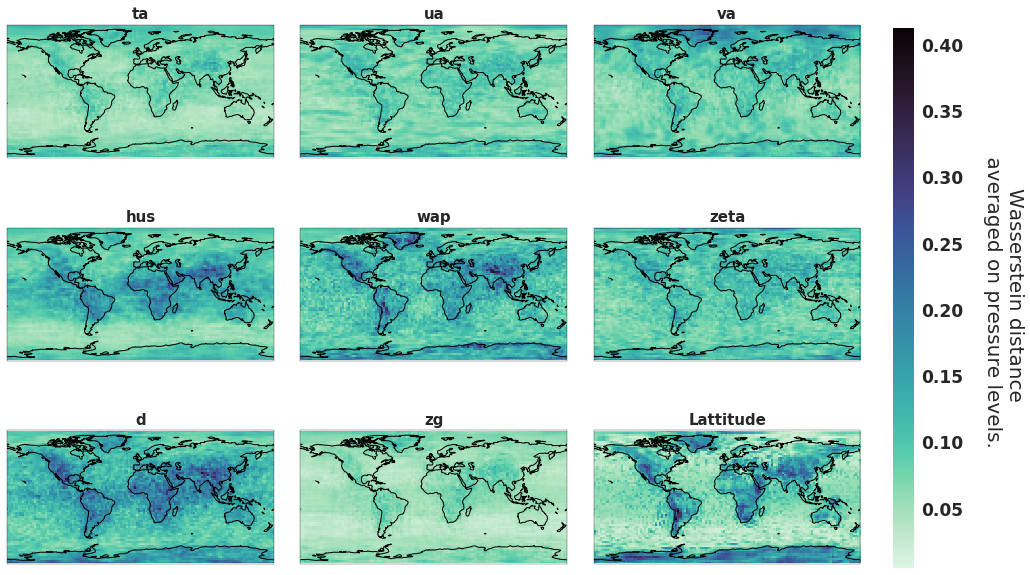

In [62]:
#wd_im = np.load('./fig_82c/wd_im_82.npy')
#imw = wd_im
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize=(15,10),
                    subplot_kw={'projection': ccrs.PlateCarree(central_longitude = 0.)})
ax = ax.reshape(1,-1)
#fig.suptitle(f'Wasserstein distance for each fields \n averaged on pressure levels.', fontsize = 24, fontweight = fontweight)
fig.subplots_adjust(top = 0.9,left=0.01,right=0.8,bottom=0.08, wspace = 0.1, hspace = 0.1)

cbar_max = np.amax(imw)
cbar_min = np.amin(imw)   
cnt = 1
for k in range(8):
    ax[0,cnt-1].coastlines(linewidth = 1)
    im = ax[0,cnt-1].imshow(imw[::-1,:,k], cmap='mako_r', vmin=cbar_min, vmax=cbar_max,
                            transform=ccrs.PlateCarree(central_longitude=180.))
    
    ax[0,cnt-1].set_title(chan_titles[k*10][:-5], fontsize = 15, fontweight = fontweight)


    
    #ax[0,cnt-1].grid(False)
    cax = fig.add_axes([0.83, 0.11, 0.02, 0.75])
    fig.colorbar(im, cax, orientation='vertical')
    cax.tick_params(axis='both', which='major', labelsize=17)
    cax.set_ylabel('Wasserstein distance \n averaged on pressure levels.', rotation=270, fontsize = 20, labelpad=60)
    cnt+=1
ax[0,-1].coastlines(linewidth = 1)
im = ax[0,-1].imshow(imw[::-1,:,-1], cmap='mako_r', vmin=cbar_min, vmax=cbar_max,
                            transform=ccrs.PlateCarree(central_longitude=180.))
ax[0,-1].set_title('Lattitude', fontsize = 15, fontweight = fontweight)
if True:
    plt.savefig(f'./fig_{N_fields}c/wd_spatial_var.pdf')   

/softs/anaconda3/envs/tf1.12-cuda10-py36/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  import sys


0.0019018733024597158 1.2654076163236896
0
1
2
3
4
5
6
7
8
9


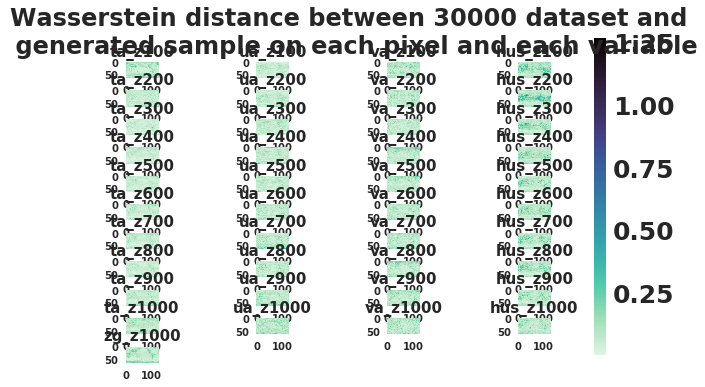

In [63]:
#lon = genfromtxt('/scratch/coop/besombes/Puma_Project/data/raw/lon.csv', delimiter=',')
#lat = genfromtxt('/scratch/coop/besombes/Puma_Project/data/raw/lat.csv', delimiter=',')
#np.save('./fig_82c/wd_im_82', wd_im)

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(nrows = N_lvls+1, ncols = 4)
plt.tight_layout()
ax = ax.reshape(1,-1)
fig.suptitle(f'Wasserstein distance between 30000 dataset and \n generated sample on each pixel and each variable',
             fontsize = 24, fontweight = fontweight)
fig.subplots_adjust(top = 0.84,left=0.05,right=.9,bottom=0.08, wspace = 0.35, hspace = 0.75)
cnt = 0
cbar_max = np.amax(wd_im)
cbar_min = np.amin(wd_im)   
print(cbar_min, cbar_max)
for k in range(N_lvls):
    print(k)
    im =  ax[0,k*4+0].imshow(wd_im[:,:,k+0*N_lvls], cmap='mako_r', vmin=cbar_min, vmax=cbar_max)
    im =  ax[0,k*4+1].imshow(wd_im[:,:,k+1*N_lvls], cmap='mako_r', vmin=cbar_min, vmax=cbar_max)
    im =  ax[0,k*4+2].imshow(wd_im[:,:,k+2*N_lvls], cmap='mako_r', vmin=cbar_min, vmax=cbar_max)
    im =  ax[0,k*4+3].imshow(wd_im[:,:,k+3*N_lvls], cmap='mako_r', vmin=cbar_min, vmax=cbar_max)
    #im =  ax[0,k*N_lvls+4].imshow(wd_im[0,:,:,k+4*N_lvls], cmap='mako_r', vmin=cbar_min, vmax=cbar_max)
    #im =  ax[0,k+2*N_lvls].imshow(wd_im[0,:,:,k], cmap='mako_r', vmin=cbar_min, vmax=cbar_max)
    ax[0,k*4+0].set_title(chan_titles[k+0*N_lvls], fontsize = 15, fontweight = fontweight)
    ax[0,k*4+1].set_title(chan_titles[k+1*N_lvls], fontsize = 15, fontweight = fontweight)
    ax[0,k*4+2].set_title(chan_titles[k+2*N_lvls], fontsize = 15, fontweight = fontweight)
    ax[0,k*4+3].set_title(chan_titles[k+3*N_lvls], fontsize = 15, fontweight = fontweight)
    #ax[0,k*N_lvls+4].set_title(chan_titles[k+3*N_lvls], fontsize = 25, fontweight = fontweight)
    #ax[0,cnt-1].coastlines()

    ax[0,k*4+0].grid(False)
    ax[0,k*4+1].grid(False)
    ax[0,k*4+2].grid(False)
    ax[0,k*4+3].grid(False)
    
    cnt+=1



ax[0,-1].remove()
ax[0,-2].remove()
ax[0,-3].remove()

ax[0,-4].grid(False)
ax[0,-4].imshow(wd_im[:,:,-1], cmap='mako_r', vmin=cbar_min, vmax=cbar_max)
ax[0,-4].set_title(chan_titles[-2], fontsize = 15, fontweight = fontweight)
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
fig.colorbar(im, cax, orientation='vertical')
cax.tick_params(axis='both', which='major', labelsize=25)
#ax[0,-1].remove()
if True:
    plt.savefig(f'./fig_{N_fields}c/wdistance_channels.pdf')   
#plt.tight_layout()    
#plt.show()

(64, 128, 81)
[0.02076313 0.2519086 ]


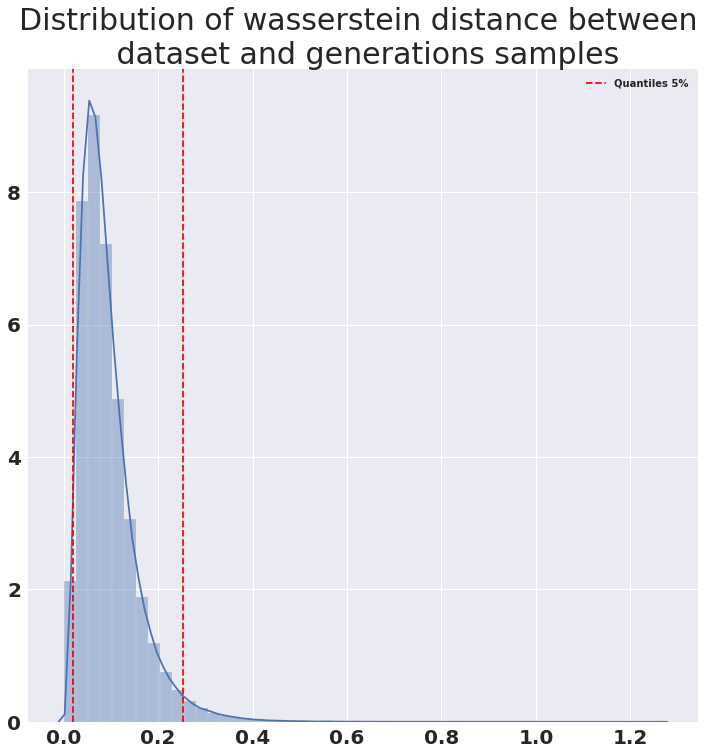

In [64]:
wd_flat = wd_im.reshape(1,-1)
print(wd_im.shape)
q = np.quantile(wd_flat, [0.025, 0.975])
print(q)

plt.figure(figsize = (12,12))
plt.title('Distribution of wasserstein distance between \n dataset and generations samples', fontsize = 30)
sns.distplot(wd_flat)
plt.axvline(q[0], color = 'red', linestyle = '--')
plt.axvline(q[1], color = 'red', linestyle = '--')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.legend([ 'Quantiles 5%'])

if True:
    plt.savefig(f'./fig_{N_fields}c/dist_wd_qt.pdf')

In [65]:
#Wasserstein distance for each fields.
leg = [ 'ta','ua','va', 'wa', 'pl']
lvl = 'z200'
#plt.figure(figsize = (15,12))
#plt.title('Distribution of wasserstein distance between \n dataset and generations samples', fontsize = 30)
#for i in range(0,N_fields-1,5):
#    wd_flat_f = wd_im.reshape(N_fields-1,-1)
#
#    q = np.quantile(wd_flat_f[i,:], [0.025, 0.975])
#    #print(q)
#
#
#    
#    sns.distplot(wd_flat_f[i,:], hist = False, label = leg[int(i/5)]+'_'+lvl)
#    #plt.axvline(q[0], color = 'red', linestyle = '--')
#    #plt.axvline(q[1], color = 'red', linestyle = '--')
#    plt.xticks(fontsize = 20)
#    plt.yticks(fontsize = 20)
#    plt.legend()

In [66]:
print(lvls)
print(var)
lvl_idx = np.array(wd_im, dtype = str)
for i in range(len(lvls)):
    lvl_idx[:,:,i::N_lvls] = f'z{str(lvls[i])}'
print(lvl_idx[:,:,0])
lvl_idx[:,:,-1] = 'z1000'


var_idx = np.array(wd_im, dtype = str)
for i in range(len(var)):
    var_idx[:,:,i*N_lvls:(i+1)*N_lvls] = f'{var[i]}'

var_idx[:,:,-1] = 'ps'
print(var_idx[0,0,:])
print(var_idx.shape)
print(lvl_idx.shape)
print(wd_im.shape)

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
['ta', 'ua', 'va', 'hus', 'wap', 'zeta', 'd', 'zg']
[['z100' 'z100' 'z100' ... 'z100' 'z100' 'z100']
 ['z100' 'z100' 'z100' ... 'z100' 'z100' 'z100']
 ['z100' 'z100' 'z100' ... 'z100' 'z100' 'z100']
 ...
 ['z100' 'z100' 'z100' ... 'z100' 'z100' 'z100']
 ['z100' 'z100' 'z100' ... 'z100' 'z100' 'z100']
 ['z100' 'z100' 'z100' ... 'z100' 'z100' 'z100']]
['ta' 'ta' 'ta' 'ta' 'ta' 'ta' 'ta' 'ta' 'ta' 'ta' 'ua' 'ua' 'ua' 'ua'
 'ua' 'ua' 'ua' 'ua' 'ua' 'ua' 'va' 'va' 'va' 'va' 'va' 'va' 'va' 'va'
 'va' 'va' 'hus' 'hus' 'hus' 'hus' 'hus' 'hus' 'hus' 'hus' 'hus' 'hus'
 'wap' 'wap' 'wap' 'wap' 'wap' 'wap' 'wap' 'wap' 'wap' 'wap' 'zeta' 'zeta'
 'zeta' 'zeta' 'zeta' 'zeta' 'zeta' 'zeta' 'zeta' 'zeta' 'd' 'd' 'd' 'd'
 'd' 'd' 'd' 'd' 'd' 'd' 'zg' 'zg' 'zg' 'zg' 'zg' 'zg' 'zg' 'zg' 'zg' 'zg'
 'ps']
(64, 128, 81)
(64, 128, 81)
(64, 128, 81)


In [67]:
cm = ['rocket','rocket','rocket','rocket','rocket','rocket','Blues','Blues','Blues','Purples','Purples','Purples',
      'PuRd','PuRd','PuRd','copper','copper','copper','viridis','viridis','viridis',
      'Greens_r','Greys']

index = wd_im.shape
print(index)
d = {'var': var_idx.reshape(-1),
     'val': wd_im.reshape(-1),
     'lvl': lvl_idx.reshape(-1)}

sta = pd.Series(d)
df_wd = pd.DataFrame(data = d, index = np.arange(index[0]*index[1]*index[2]))
df_wd.head()



(64, 128, 81)


,var,val,lvl
0,ta,0.242012,z100
1,ta,0.048698,z200
2,ta,0.047695,z300
3,ta,0.102229,z400
4,ta,0.049466,z500


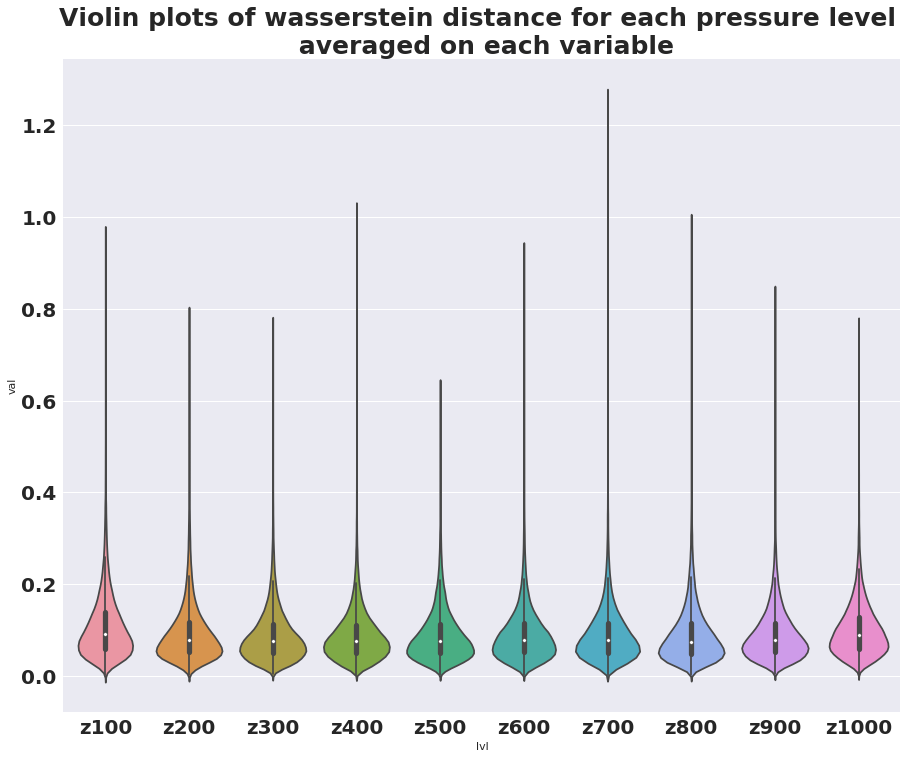

In [68]:
plt.figure(figsize = (15,12))
sns.violinplot(x="lvl", y="val", data=df_wd)
plt.title('Violin plots of wasserstein distance for each pressure level \n averaged on each variable', fontsize = 25, fontweight = 'bold')

plt.tick_params(axis='both', labelsize=tick_size)

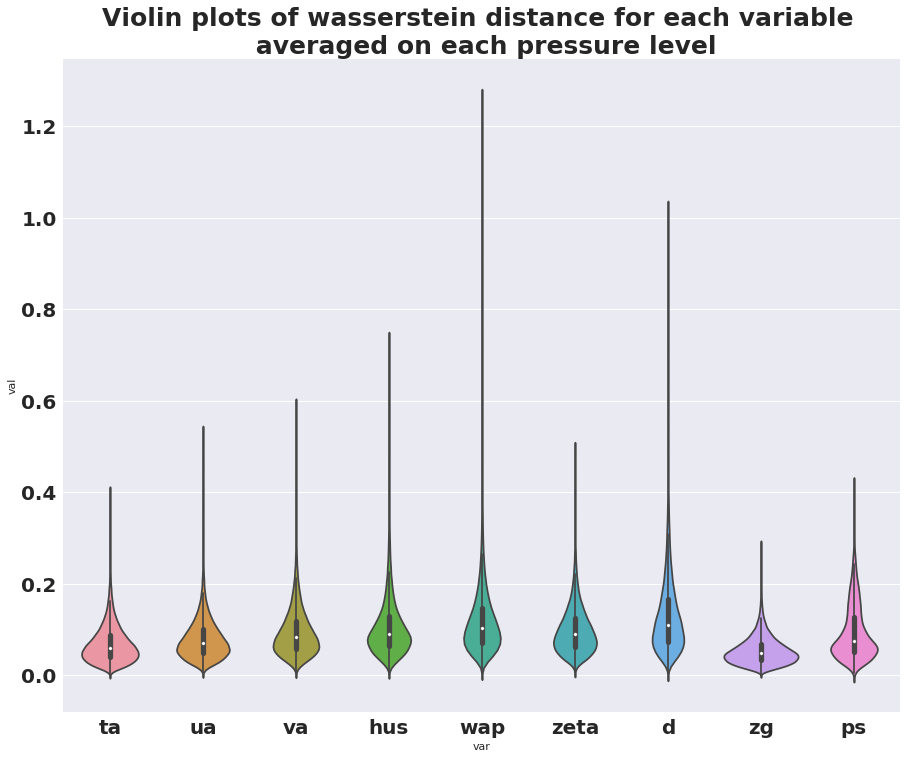

In [69]:
plt.figure(figsize = (15,12))
sns.violinplot(x="var", y="val", data=df_wd)
plt.title('Violin plots of wasserstein distance for each variable \n averaged on each pressure level', fontsize = 25, fontweight = 'bold')
plt.tick_params(axis='both', labelsize=tick_size)
plt.savefig(f'./fig_{N_fields}c/dist_wd_vars.pdf')

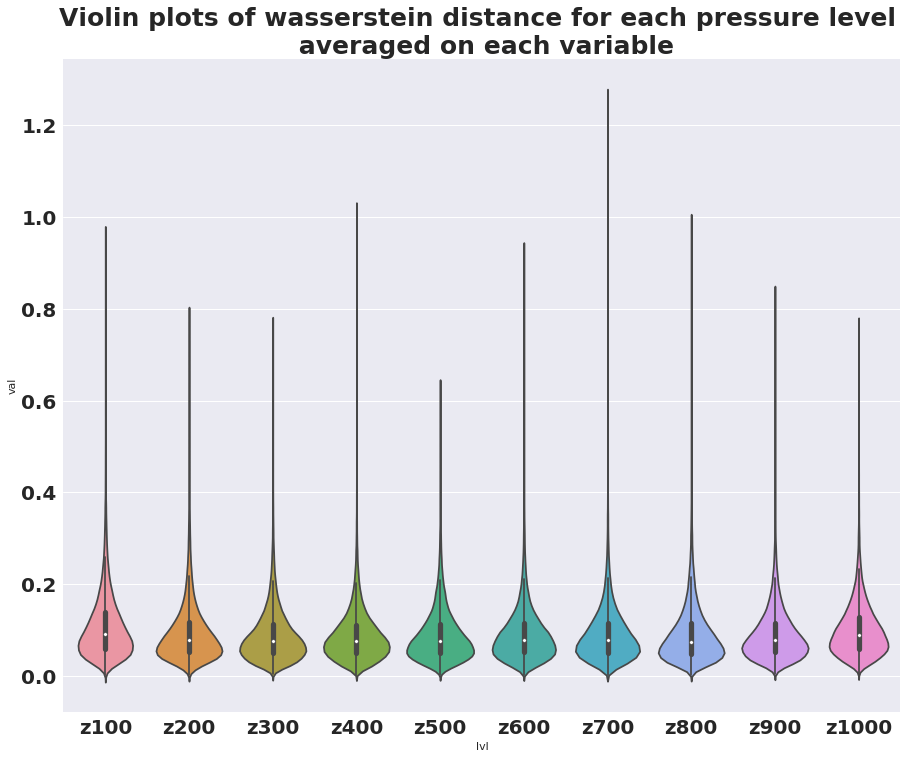

In [70]:
plt.figure(figsize = (15,12))
sns.violinplot(x="lvl", y="val", data=df_wd)
plt.title('Violin plots of wasserstein distance for each pressure level \n averaged on each variable', fontsize = 25, fontweight = 'bold')

plt.tick_params(axis='both', labelsize=tick_size)



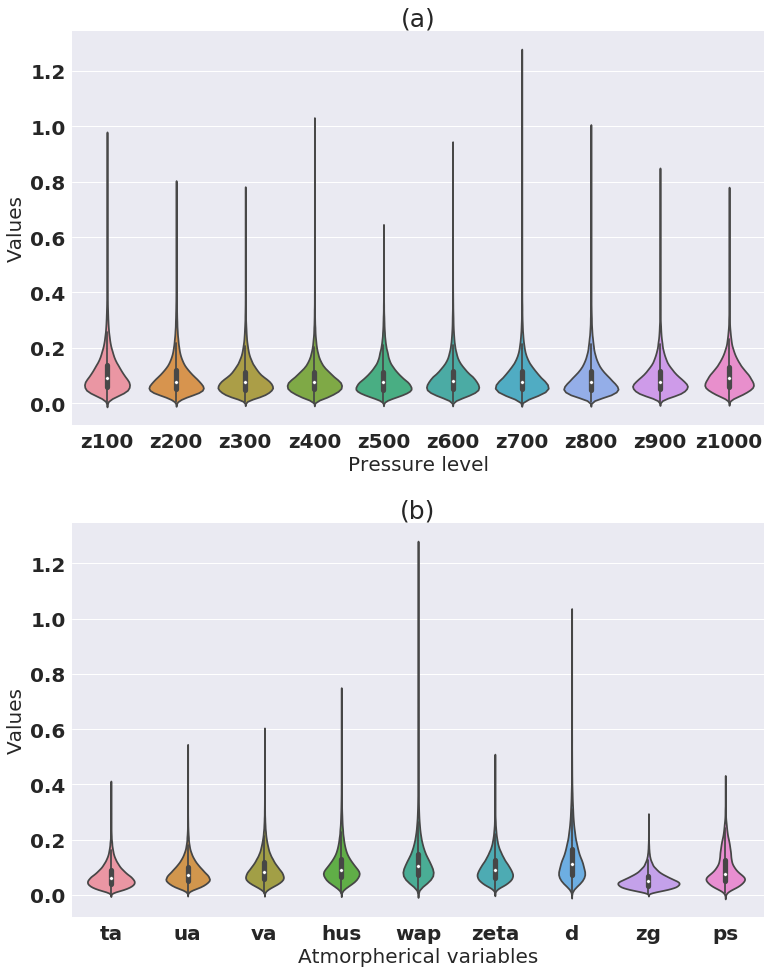

In [71]:
fig, ax = plt.subplots(2,1, figsize = (12,15))
fig.subplots_adjust(top = 0.9,left=0.1,right=.9,bottom=0.08, wspace = 0.05, hspace = 0.25)

ax[0].set_title('(a)', fontsize = 25)
sns.violinplot(x="lvl", y="val", data=df_wd, ax = ax[0])
ax[0].set_xlabel('Pressure level', fontsize = 20)
ax[0].set_ylabel('Values', fontsize = 20)
ax[0].tick_params(axis='both', labelsize=20)


sns.violinplot(x="var", y="val", data=df_wd, ax = ax[1])
plt.title('(b)', fontsize = 25)
ax[1].set_xlabel('Atmorpherical variables', fontsize = 20)
ax[1].set_ylabel('Values', fontsize = 20)
plt.tick_params(axis='both', labelsize=20)
plt.savefig(f'./fig_{N_fields}c/double_violin_plot.pdf')

In [72]:
wd_max = np.amax(wd_im)
print(wd_max)

idx_max = np.argwhere(wd_im==wd_max)
print((idx_max))

print(type(idx_max))

wd_min = np.amin(wd_im)
print(wd_min)

idx_min = np.argwhere(wd_im==wd_min)
print((idx_min))

print(type(idx_min))

1.2654076163236896
[[57 16 46]]
<class 'numpy.ndarray'>
0.0019018733024597158
[[42 18 76]]
<class 'numpy.ndarray'>


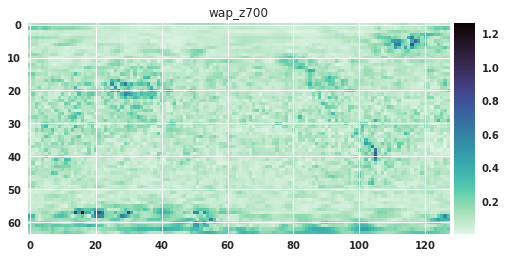

In [73]:
fig = plt.figure()
ax = plt.subplot(111)
im = plt.imshow(wd_im[:,:,idx_max[0][-1]], cmap = 'mako_r')
plt.title(chan_titles[idx_max[0][-1]])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax = cax)

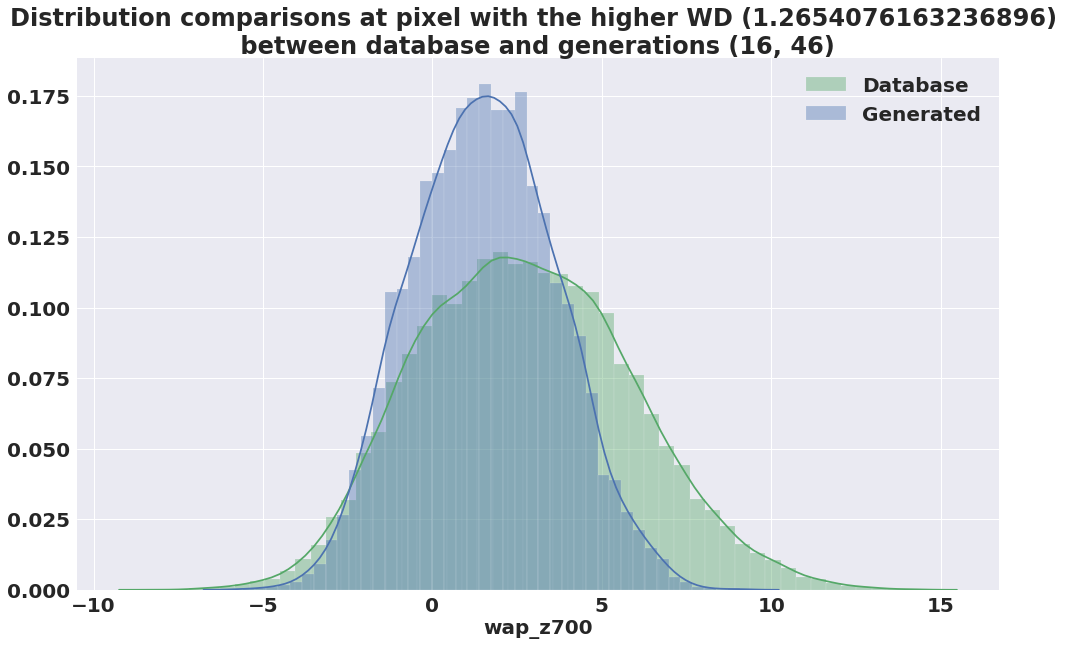

In [74]:
fig, ax = plt.subplots(figsize=(16,9))
plt.suptitle(f'Distribution comparisons at pixel with the higher WD ({wd_max}) \n between database and generations {idx_max[0][1], idx_max[0][2]} '
            , fontsize = 24, fontweight = fontweight)

fig.subplots_adjust(top = 0.9,left=0.1,right=.9,bottom=0.08, wspace = 0.1, hspace = 0.3)

plt.subplot(1,1,1)
sns.distplot(X_train[:,idx_max[0][0], idx_max[0][1], idx_max[0][2]], rug=False, hist=True, kde = True,
             norm_hist = False, color = 'g', bins = None)


sns.distplot(fk_imgs[:,idx_max[0][0], idx_max[0][1], idx_max[0][2]], rug=False, hist=True, kde = True,
             norm_hist = False, color = 'b', bins = None)
plt.xlabel(chan_titles[idx_max[0][2]], fontsize = 20, fontweight = 'bold')
#plt.xlabel(var2plot[0][:-5], fontsize = 20, fontweight = fontweight)
plt.legend(['Database',"Generated" ], fontsize = 20)
plt.tick_params(axis='both', labelsize=tick_size)
if True:
    plt.savefig('./fig_22c/distrib_comp_high_wd.pdf')

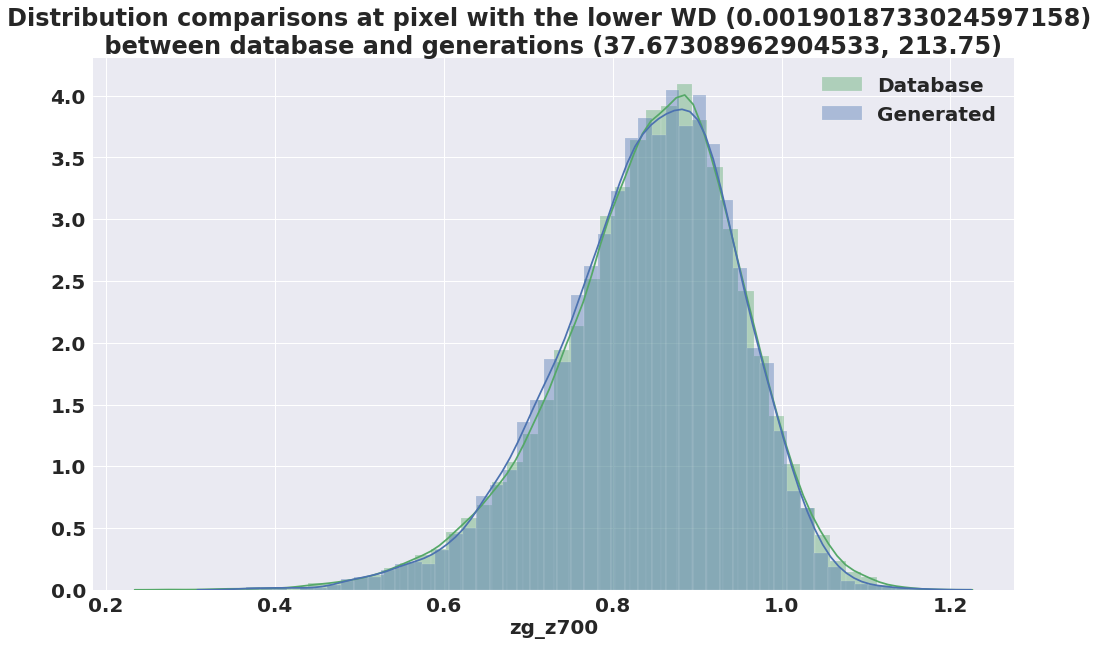

In [76]:
lon = np.genfromtxt('/scratch/coop/besombes/Puma_Project/data/raw/lon.csv', delimiter=',')
lat = np.genfromtxt('/scratch/coop/besombes/Puma_Project/data/raw/lat.csv', delimiter=',')

fig, ax = plt.subplots(figsize=(16,9))
plt.suptitle(f'Distribution comparisons at pixel with the lower WD ({wd_min}) \n between database and generations {lat[idx_min[0][1]], lon[idx_min[0][2]]} '
            , fontsize = 24, fontweight = fontweight)

fig.subplots_adjust(top = 0.9,left=0.1,right=.9,bottom=0.08, wspace = 0.1, hspace = 0.3)

plt.subplot(1,1,1)
sns.distplot(X_train[:,idx_min[0][0], idx_min[0][1], idx_min[0][2]], rug=False, hist=True, kde = True,
             norm_hist = False, color = 'g', bins = None)


sns.distplot(fk_imgs[:,idx_min[0][0], idx_min[0][1], idx_min[0][2]], rug=False, hist=True, kde = True,
             norm_hist = False, color = 'b', bins = None)

#plt.xlabel(var2plot[0][:-5], fontsize = 20, fontweight = fontweight)
plt.legend(['Database',"Generated" ], fontsize = 20)
plt.tick_params(axis='both', labelsize=tick_size)
plt.xlabel(chan_titles[idx_min[0][2]], fontsize = 20, fontweight = 'bold')
if True:
    plt.savefig(f'./fig_{N_fields}c/distrib_comp_low_wd.pdf')

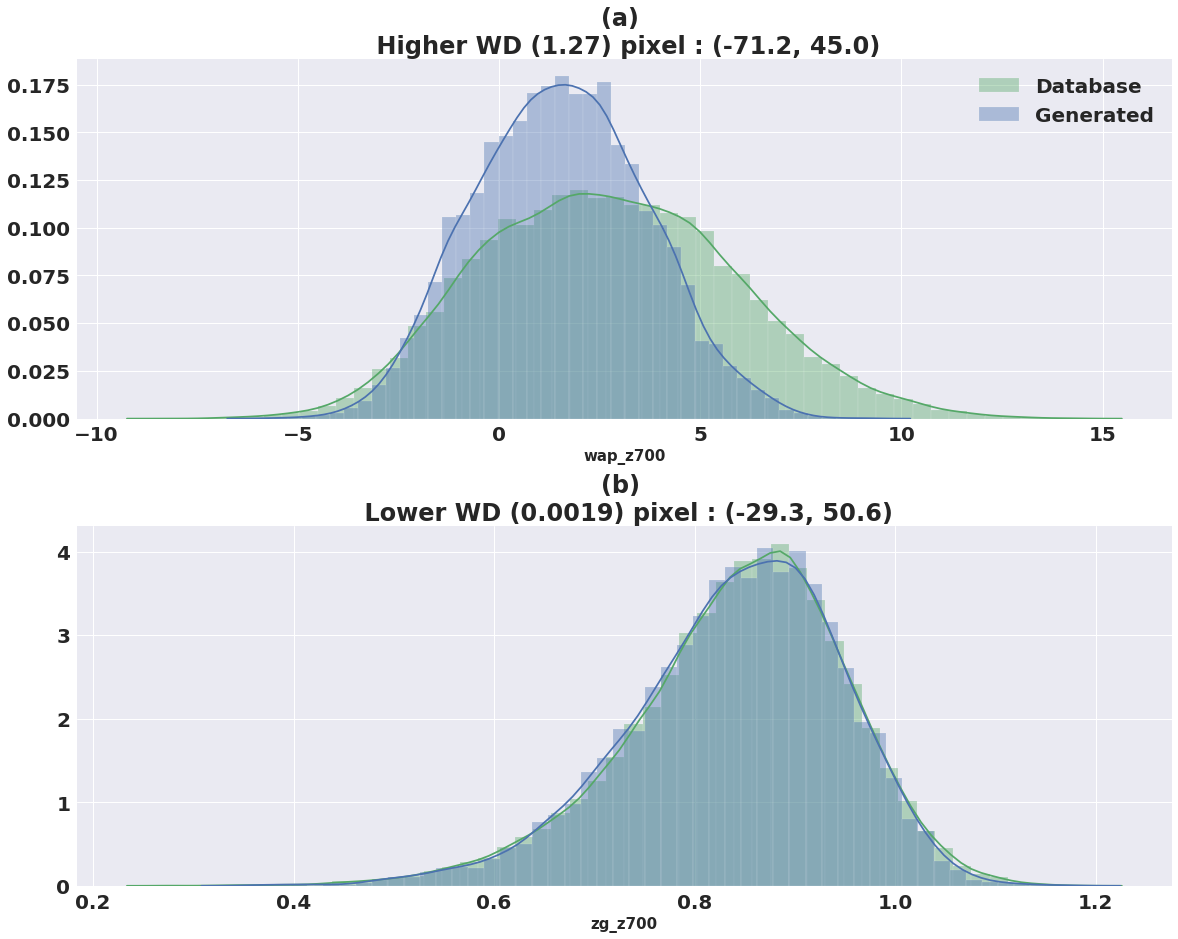

In [78]:
fig, ax = plt.subplots(figsize=(19,14))

fig.subplots_adjust(top = 0.9,left=0.1,right=.9,bottom=0.08, wspace = 0.1, hspace = 0.3)

plt.subplot(2,1,1)
sns.distplot(X_train[:,idx_max[0][0], idx_max[0][1], idx_max[0][2]], rug=False, hist=True, kde = True,
             norm_hist = False, color = 'g', bins = None)


sns.distplot(fk_imgs[:,idx_max[0][0], idx_max[0][1], idx_max[0][2]], rug=False, hist=True, kde = True,
             norm_hist = False, color = 'b', bins = None)
plt.title(f'(a) \n Higher WD ({wd_max:.3}) pixel : ({lat[idx_max[0][0]]:.3}, {lon[idx_max[0][1]]:.3})'
            , fontsize = 24, fontweight = fontweight)

plt.xlabel(chan_titles[idx_max[0][2]], fontsize = 15, fontweight = 'bold')
#plt.xlabel(var2plot[0][:-5], fontsize = 20, fontweight = fontweight)
plt.legend(['Database',"Generated" ], fontsize = 20)
plt.tick_params(axis='both', labelsize=tick_size)

plt.subplot(2,1,2)
sns.distplot(X_train[:,idx_min[0][0], idx_min[0][1], idx_min[0][2]], rug=False, hist=True, kde = True,
             norm_hist = False, color = 'g', bins = None)


sns.distplot(fk_imgs[:,idx_min[0][0], idx_min[0][1], idx_min[0][2]], rug=False, hist=True, kde = True,
             norm_hist = False, color = 'b', bins = None)
plt.title(f'(b) \n Lower WD ({wd_min:.3}) pixel : ({lat[idx_min[0][0]]:.3}, {lon[idx_min[0][1]]:.3})'
            , fontsize = 24, fontweight = fontweight)
#plt.xlabel(var2plot[0][:-5], fontsize = 20, fontweight = fontweight)
#plt.legend(['Database',"Generated" ], fontsize = 20)
plt.tick_params(axis='both', labelsize=tick_size)
plt.xlabel(chan_titles[idx_min[0][2]], fontsize = 15, fontweight = 'bold')
plt.savefig('./fig_82c/higher_lower_wd.pdf')

In [ ]:
print(idx_min)
print(idx_max)
print(lat[idx_max[0][0]])
print(lat)